## Eimeria Automatic Classification Pipeline

This notebook automates the classification process for *Eimeria* oocysts based on morphological features obtained through automatic image processing.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn modules
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.svm import SVC

# Evaluation metrics
from sklearn.metrics import (
    precision_score, recall_score, f1_score, classification_report, 
    confusion_matrix, accuracy_score, roc_curve, auc, make_scorer
)

### Data preparation

In [2]:
# Load the dataset
data = pd.read_excel("D:/Eimeria_Classification_TFG/Eimeria_Classification_TFG/data/auto_measurements.xlsx")

# Display the first few rows
print("Head of the dataset:")
print(data.head())

# Get a summary of the dataset (data types, non-null counts, etc.)
print("\nDataset info:")
print(data.info())

# Descriptive statistics for numerical features
print("\nDescriptive statistics:")
print(data.describe())

# Summary
total = len(data)
print(f"Total number of observations: {total}")

# Print number of samples per species
species_counts = data['Species'].value_counts()
print("\nNumber of observations per species:")
print(species_counts)

Head of the dataset:
                         Filename       Species  Length   Width     Area  \
0    E.gallopavonis-079_40X_1.tif  Gallopavonis  191.43  141.40  21047.5   
1   E.gallopavonis-079_40X_10.tif  Gallopavonis  167.86  150.45  19612.0   
2  E.gallopavonis-079_40X_100.tif  Gallopavonis  165.98  129.80  16766.0   
3  E.gallopavonis-079_40X_100.tif  Gallopavonis  187.75  154.62  22770.0   
4  E.gallopavonis-079_40X_101.tif  Gallopavonis  178.34  144.55  20193.0   

   Perimeter  Aspect_Ratio    IC  Extent  Solidity  Circularity  Eccentricity  
0     591.23          0.74  1.35    0.74      0.96         0.76          0.67  
1     559.33          0.90  1.12    0.74      0.97         0.79          0.44  
2     525.33          0.78  1.28    0.73      0.96         0.76          0.62  
3     589.41          0.82  1.21    0.74      0.98         0.82          0.57  
4     558.30          0.81  1.23    0.75      0.98         0.81          0.59  

Dataset info:
<class 'pandas.core.frame.D

In [3]:
# Check for missing values in each column
print(data.isnull().sum())

Filename        0
Species         0
Length          0
Width           0
Area            0
Perimeter       0
Aspect_Ratio    0
IC              0
Extent          0
Solidity        0
Circularity     0
Eccentricity    0
dtype: int64


In [4]:
# Check for duplicate rows
duplicate_count = data.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")

# Remove duplicate rows if necessary
data = data.drop_duplicates()

Number of duplicate rows: 0


### Exploratory Data Analysis (EDA)

C:\Users\apf6226\AppData\Local\Temp\ipykernel_17744\3535450624.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Species', data=data, palette="muted")


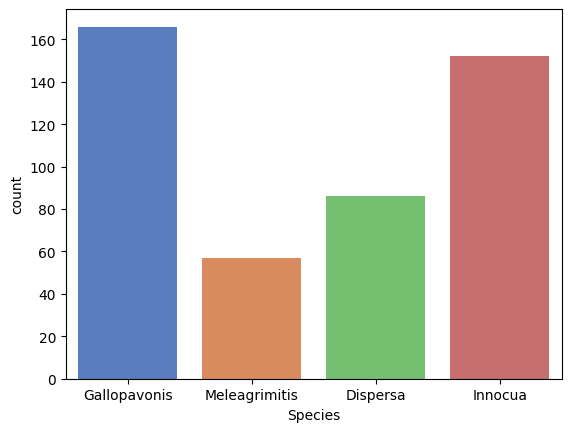

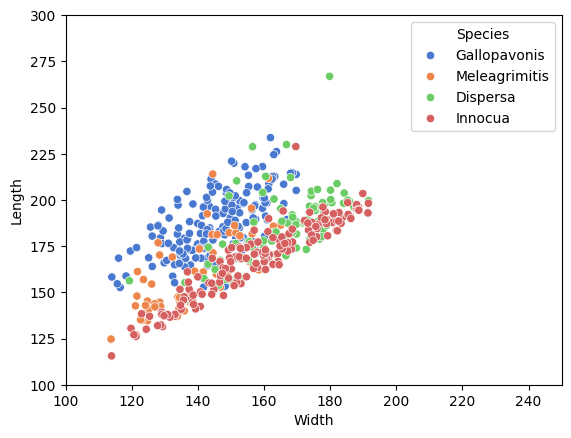

In [5]:
# Visualize the distribution of classes
sns.countplot(x='Species', data=data, palette="muted")
plt.show()

# Scatter plot for Length and Width
sns.scatterplot(x='Width', y='Length', hue='Species', data=data, palette="muted")
plt.xlim(100, 250)
plt.ylim(100, 300)

plt.show()

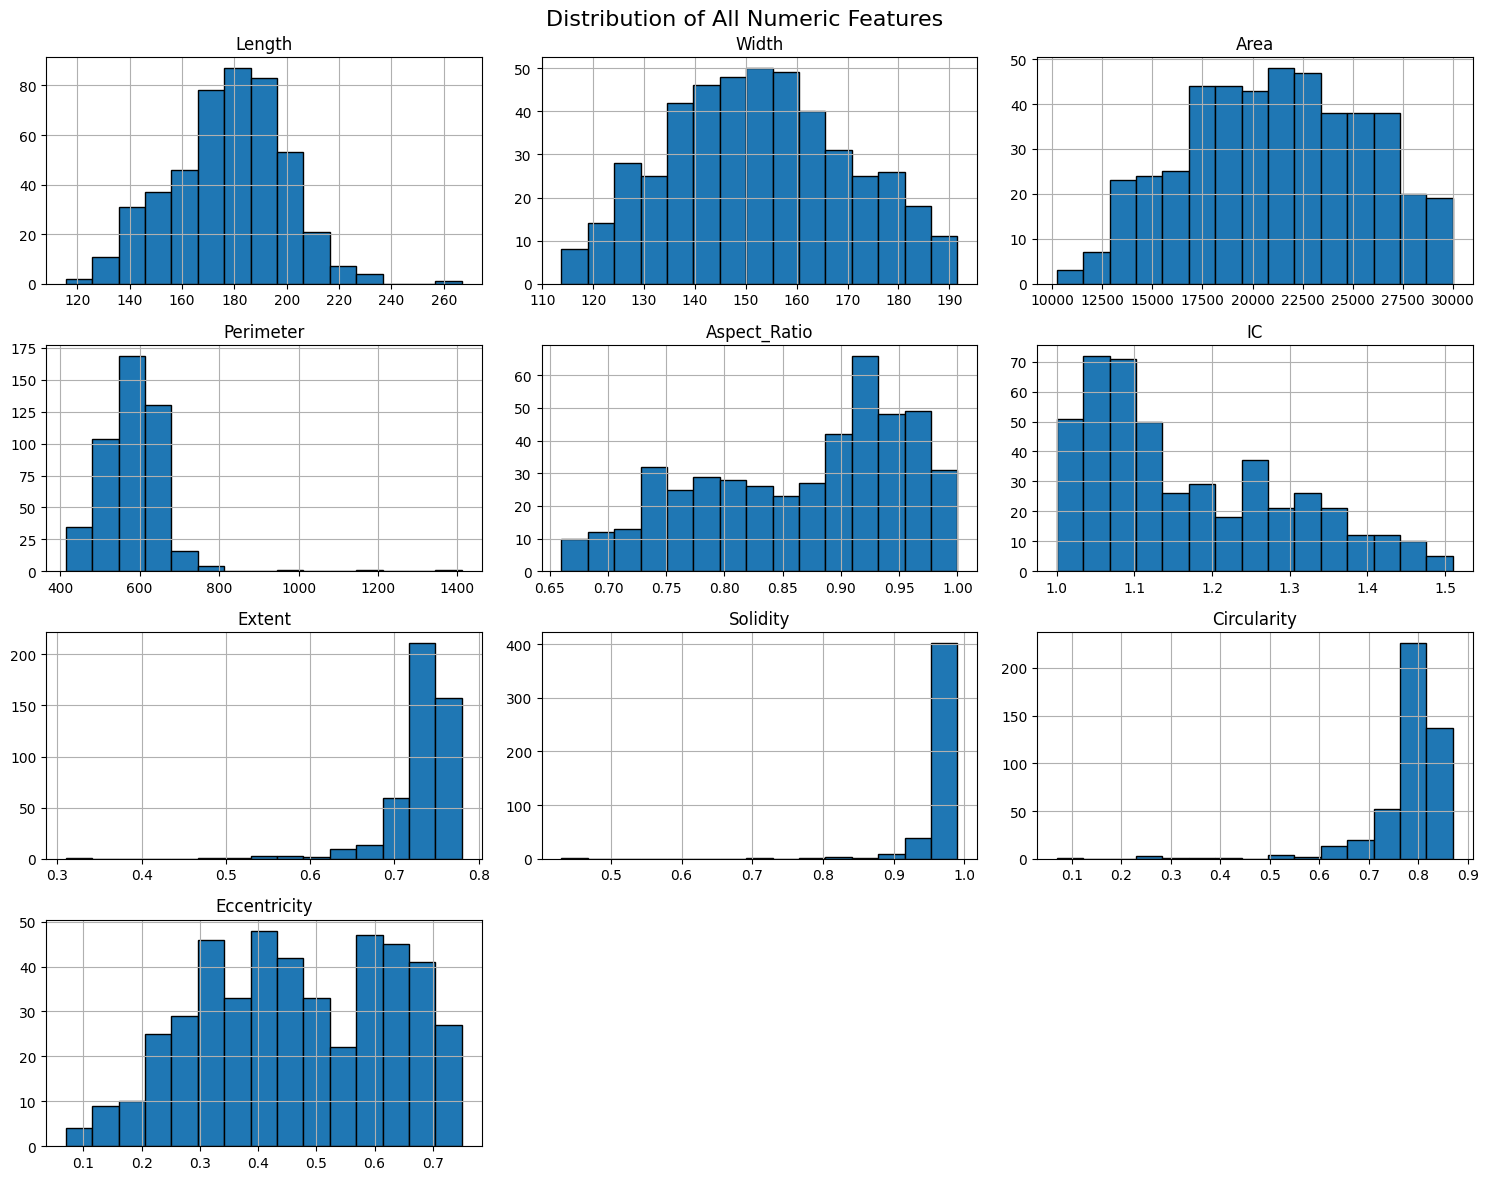

In [6]:
data.drop(columns='Species').hist(figsize=(15, 12), bins=15, edgecolor='black')
plt.suptitle('Distribution of All Numeric Features', fontsize=16)
plt.tight_layout()
plt.show()

### Split the dataset

In [7]:
# Separate features and target
X = data.drop(columns=['Species','Filename'])  
y = data['Species']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24, stratify=y)


In [8]:
# Standardize features
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

In [9]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to balance classes in training set
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_std, y_train)

# Keep test set unchanged
X_test_smote = X_test_std 
y_test_smote = y_test


### Principal Component Analysis

Explained variance ratio by PCA components:
[0.37651435 0.3602466  0.23074756]
Number of PCA components: 3


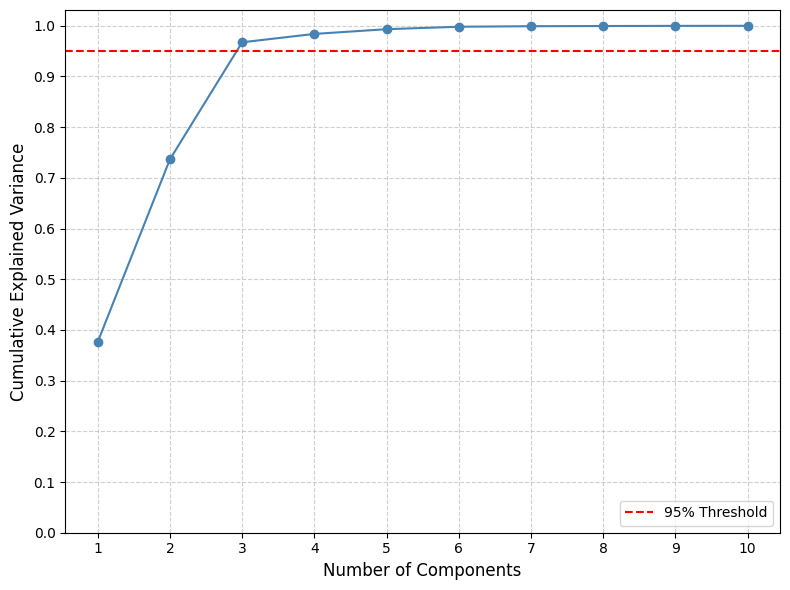

In [10]:
from sklearn.decomposition import PCA

# Keep enough components to explain ~95% of the variance
pca = PCA(n_components=0.95)  # Retain 95% variance
X_train_pca = pca.fit_transform(X_train_smote)
X_test_pca = pca.transform(X_test_smote)

# Display PCA explained variance ratio
print("Explained variance ratio by PCA components:")
print(pca.explained_variance_ratio_)
# Display the number of components
print(f"Number of PCA components: {pca.n_components_}")

# Fit PCA with all components (or with a fixed number)
pca_full = PCA()
pca_full.fit(X_train_smote)

# Cumulative explained variance
cum_var = np.cumsum(pca_full.explained_variance_ratio_)
n_components = len(cum_var)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(range(1, n_components + 1), cum_var, marker='o', linestyle='-', color='steelblue')
plt.axhline(y=0.95, color='red', linestyle='--', label='95% Threshold')
plt.xticks(np.arange(1, n_components + 1, 1))
plt.yticks(np.arange(0.0, 1.05, 0.1))
plt.xlabel('Number of Components', fontsize=12)
plt.ylabel('Cumulative Explained Variance', fontsize=12)
#plt.title('PCA Cumulative Explained Variance', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


In [11]:
# Feature names
feature_names = X.columns  # original feature names

# Create a DataFrame with PCA loadings
loadings = pd.DataFrame(pca.components_.T, 
                        columns=[f'PC{i+1}' for i in range(pca.n_components_)],
                        index=feature_names)

# Display the absolute loadings
abs_loadings = loadings.abs()

# Find the top contributing features for each PC
top_features_per_pc = abs_loadings.apply(lambda x: x.nlargest(3).index.tolist())

print("Top 3 contributing features per principal component:")
print(top_features_per_pc)


Top 3 contributing features per principal component:
      PC1           PC2          PC3
0    Area  Aspect_Ratio     Solidity
1  Length            IC  Circularity
2   Width  Eccentricity       Extent


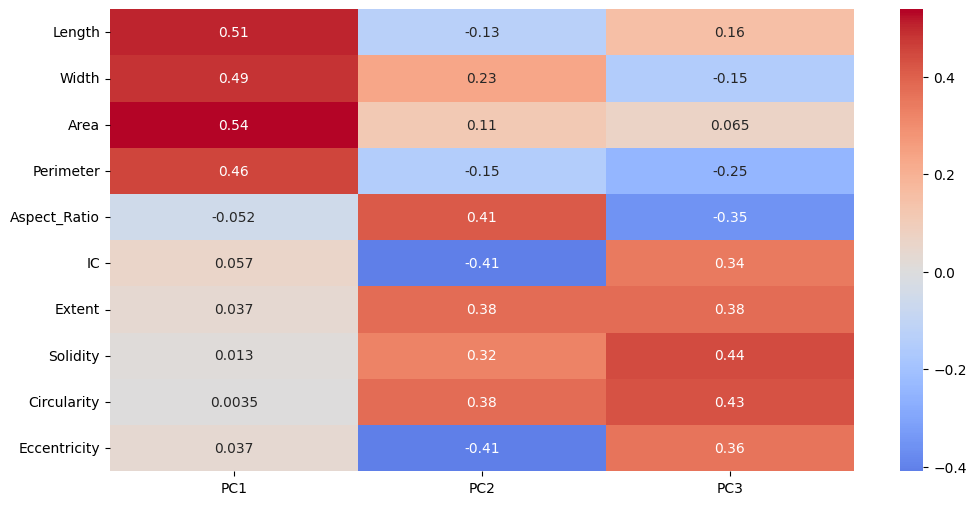

In [12]:
# Plot heatmap of loadings
plt.figure(figsize=(12, 6))
sns.heatmap(loadings, annot=True, cmap='coolwarm', center=0)
#plt.title("PCA Loadings (Feature Contributions to Each PC)")
plt.show()


### Choose and Train Classification Algorithms

In [13]:
def mean_class_accuracy(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    per_class_acc = cm.diagonal() / cm.sum(axis=1)
    return np.mean(per_class_acc)


def evaluate_svm_on_smoted(X_train, X_test, y_train, y_test, label):
    print(f"\nTraining SVM on {label} data...")

    svm = SVC()
    kf = KFold(n_splits=5, shuffle=True, random_state=24)

    mean_class_accuracies = []

    for train_idx, val_idx in kf.split(X_train):
        X_cv_train, X_cv_val = X_train[train_idx], X_train[val_idx]
        y_cv_train, y_cv_val = y_train[train_idx], y_train[val_idx]

        svm.fit(X_cv_train, y_cv_train)
        y_cv_pred = svm.predict(X_cv_val)

        mca = mean_class_accuracy(y_cv_val, y_cv_pred)
        mean_class_accuracies.append(mca)

    avg_mean_class_acc = np.mean(mean_class_accuracies)
    std_mean_class_acc = np.std(mean_class_accuracies)
    
    # Train on SMOTEd data
    svm.fit(X_train, y_train)
    y_pred = svm.predict(X_test)

    # Metrics
    test_accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

    print(f"\nSVM Evaluation Summary for {label} data:")
    print(f"  Test Accuracy:               {test_accuracy * 100:.2f}%")
    print(f"  CV Mean Class Accuracy:      {avg_mean_class_acc * 100:.2f}%")
    print(f"  CV Mean Class Accuracy Std:  {std_mean_class_acc * 100:.2f}%")
    print(f"  Precision (weighted):        {precision * 100:.2f}%")
    print(f"  Recall (weighted):           {recall * 100:.2f}%")
    print(f"  F1-score (weighted):         {f1 * 100:.2f}%")
    



In [14]:
evaluate_svm_on_smoted(X_train_smote, X_test_smote, y_train_smote, y_test_smote, label="All Features")



Training SVM on All Features data...

SVM Evaluation Summary for All Features data:
  Test Accuracy:               64.52%
  CV Mean Class Accuracy:      62.35%
  CV Mean Class Accuracy Std:  3.20%
  Precision (weighted):        64.72%
  Recall (weighted):           64.52%
  F1-score (weighted):         64.22%


In [15]:
# Use only the first two principal components
X_train_pca_2d = X_train_pca[:, :2]  # Keep only PC1 and PC2
X_test_pca_2d = X_test_pca[:, :2]

evaluate_svm_on_smoted(X_train_pca, X_test_pca, y_train_smote, y_test_smote, label="PCA Features")



Training SVM on PCA Features data...

SVM Evaluation Summary for PCA Features data:
  Test Accuracy:               68.82%
  CV Mean Class Accuracy:      61.67%
  CV Mean Class Accuracy Std:  4.62%
  Precision (weighted):        68.23%
  Recall (weighted):           68.82%
  F1-score (weighted):         68.27%


### Model Tuning

In [16]:
# Define the SVM parameter grid
param_grid_svm = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 0.01, 0.1, 1],
    'kernel': ['rbf', 'linear']
}

# Create the custom scorer
mean_class_accuracy_scorer = make_scorer(mean_class_accuracy)

grid_search_svm_all = GridSearchCV(
    estimator=SVC(probability=True),
    param_grid=param_grid_svm,
    cv=5,
    scoring=mean_class_accuracy_scorer,
    n_jobs=-1,
    verbose=1
)

grid_search_svm_all.fit(X_train_smote, y_train_smote)

print("Best SVM Parameters (All Features):", grid_search_svm_all.best_params_)
print("Best CV Mean Class Accuracy (All Features):", round(grid_search_svm_all.best_score_ * 100, 2), "%")


Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best SVM Parameters (All Features): {'C': 100, 'gamma': 1, 'kernel': 'rbf'}
Best CV Mean Class Accuracy (All Features): 76.32 %


Classification Report after Tuning All Features:
               precision    recall  f1-score   support

     Dispersa       0.29      0.41      0.34        17
 Gallopavonis       0.68      0.79      0.73        33
      Innocua       0.59      0.42      0.49        31
Meleagrimitis       0.33      0.25      0.29        12

     accuracy                           0.53        93
    macro avg       0.48      0.47      0.46        93
 weighted avg       0.54      0.53      0.52        93

Confusion Matrix after Tuning All Features:


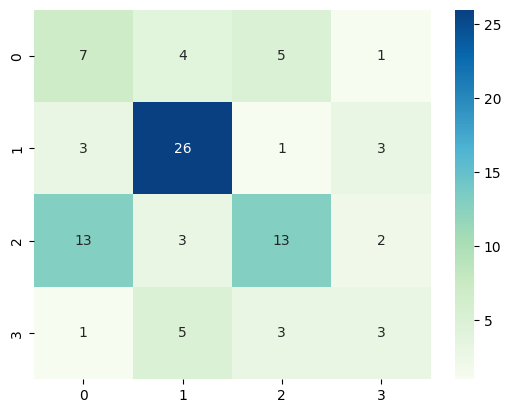

Accuracy Score after Tuning: 0.5268817204301075


In [17]:
# Get best model from grid search
best_model = grid_search_svm_all.best_estimator_

# Make predictions using the best model found in GridSearchCV
y_best_pred = best_model.predict(X_test_smote)

print("Classification Report after Tuning All Features:")
print(classification_report(y_test_smote, y_best_pred))

print("Confusion Matrix after Tuning All Features:")
conf_matrix_best = confusion_matrix(y_test_smote, y_best_pred)
sns.heatmap(conf_matrix_best, annot=True, fmt='d', cmap='GnBu')
#plt.title(f'SVM Confusion Matrix After Tuning All Features')
plt.show()

print("Accuracy Score after Tuning:", accuracy_score(y_test_smote, y_best_pred))


In [18]:

grid_search_svm_pca = GridSearchCV(
    estimator=SVC(probability=True),
    param_grid=param_grid_svm,
    cv=5,
    scoring=mean_class_accuracy_scorer,
    n_jobs=-1,
    verbose=1
)

grid_search_svm_pca.fit(X_train_pca, y_train_smote)

print("Best SVM Parameters (PCA):", grid_search_svm_pca.best_params_)
print("Best CV Mean Class Accuracy (PCA):", round(grid_search_svm_pca.best_score_ * 100, 2), "%")

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best SVM Parameters (PCA): {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
Best CV Mean Class Accuracy (PCA): 71.61 %


Classification Report after Tuning PCA:
               precision    recall  f1-score   support

     Dispersa       0.33      0.35      0.34        17
 Gallopavonis       0.70      0.85      0.77        33
      Innocua       0.53      0.52      0.52        31
Meleagrimitis       0.60      0.25      0.35        12

     accuracy                           0.57        93
    macro avg       0.54      0.49      0.50        93
 weighted avg       0.56      0.57      0.56        93

Confusion Matrix after Tuning PCA:


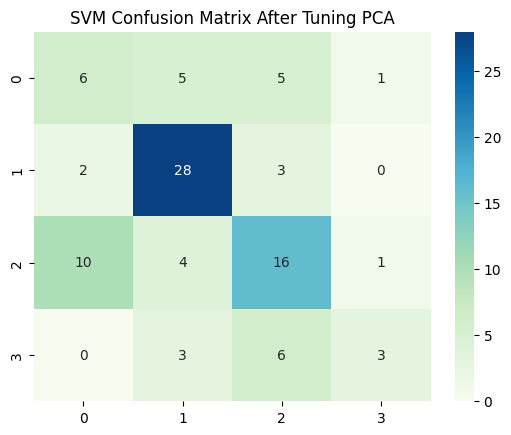

Accuracy Score after Tuning: 0.5698924731182796


In [19]:
# Get best model from grid search
best_model = grid_search_svm_pca.best_estimator_

# Make predictions using the best model found in GridSearchCV
y_best_pred = best_model.predict(X_test_pca)

print("Classification Report after Tuning PCA:")
print(classification_report(y_test_smote, y_best_pred))

print("Confusion Matrix after Tuning PCA:")
conf_matrix_best = confusion_matrix(y_test_smote, y_best_pred)
sns.heatmap(conf_matrix_best, annot=True, fmt='d', cmap='GnBu')
plt.title(f'SVM Confusion Matrix After Tuning PCA')
plt.show()

print("Accuracy Score after Tuning:", accuracy_score(y_test_smote, y_best_pred))

### Model Evaluation

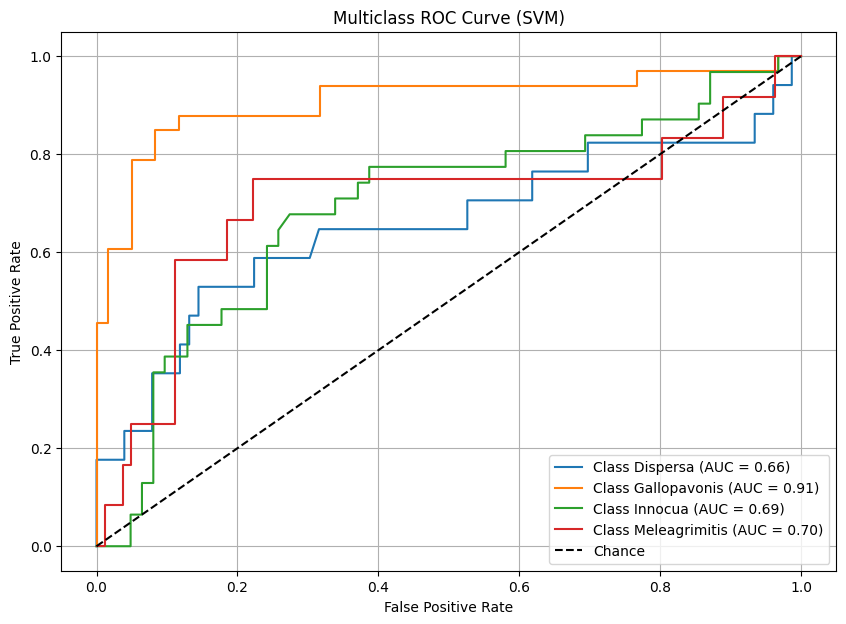

In [20]:
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier


# Binarize the output for ROC (multiclass)
classes = np.unique(y_test_smote)
y_test_bin = label_binarize(y_test_smote, classes=classes)
n_classes = y_test_bin.shape[1]

# Fit OneVsRest model (use best_model from GridSearch)
classifier = OneVsRestClassifier(best_model)
classifier.fit(X_train_smote, y_train_smote)
y_score = classifier.predict_proba(X_test_smote)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 7))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {classes[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve (SVM)')
plt.legend()
plt.grid(True)
plt.show()